# Проект телеком

## Описание проекта

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно;
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Описание данных

Данные состоят из файлов, полученных из разных источников:
contract_new.csv — информация о договоре;
personal_new.csv — персональные данные клиента;
internet_new.csv — информация об интернет-услугах;
phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Цель и задачи

Целью проекта яляется создание на основании входных данных модели, помогающей заказчику, предсказать отток клиентов, чтобы успеть предпринять меры по предотвращению оттока и не терять прибыль. 

Задачи:
- проведение исследовательского анализа:
    - загрузка данных;
    - знакомство с данными (общая информация, наименование столбцов, количество, типы данных, проверка наличия пропусков);
    - проверка на наличие дубликатов;
- предобработка данных:
    - приведение всех таблиц в одну общую;
    - преобразование типов данных;
    - заполнение пропусков;
    - исследование корреляции данных;
    - при необходимости создание новых признаков;
    - выделение признаков и целевого признака;
- моделирование:
    - исследование разных алгоритмов модели;
    - подборка гипермапарметров, оценка кросс-валидацией;
    - тестирование лучшей модели;
- вывод и оценка результатов применительно к нашей бизнес-задаче

## Исследовательский анализ данных

### Проверка основной информации

In [1]:
!pip install phik
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from catboost.utils import get_confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import phik

In [3]:
try:
    data_contract = pd.read_csv('/datasets/contract_new.csv')
    data_personal = pd.read_csv('/datasets/personal_new.csv')
    data_internet = pd.read_csv('/datasets/internet_new.csv')
    data_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    data_contract = pd.read_csv('https://code.s3.yandex.net//datasets//contract_new.csv')
    data_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    data_internet = pd.read_csv('https://code.s3.yandex.net//datasets//internet_new.csv')
    data_phone = pd.read_csv('https://code.s3.yandex.net//datasets//phone_new.csv')

#### Данные о контрактах

In [4]:
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
data_contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [6]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
data_contract.duplicated().sum()

0

In [8]:
data_contract.duplicated(subset=['customerID']).sum()

0

In [9]:
clients_out = data_contract['customerID'][data_contract['EndDate']!='No']
percent_out = len(clients_out) / len(data_contract['customerID'])
print(f'Процент ушедших клиентов: {percent_out:.2%}')

Процент ушедших клиентов: 15.63%


Представлены данные о 7043 клиентах. Пропуски и дубликаты отсутствуют. Основной тип данных - object. Численные объекты необходимо привести к типу float, BeginDate к типу datetime, категориальные к булевуму типу.

Процент ушедших клиентов составлет 15.63 %

Ушедшие клиенты в среднем ежемесячно платили больше

#### Персональные данные

In [10]:
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [11]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Представлены персональные данные о 7043 клиентах, пропуски и дубликаты отсутствуют. Все категориальные признаки типа object должны быть преобразованы в 0/1.

#### Данные о польовании интернет-услугами

In [12]:
data_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
data_internet.duplicated().sum()

0

Услугами интернета пользуются 5517 клиентов. Пропусков и дубликатов нет. Категориальные признаки типа object подлежат изменению типа данных на 0/1.

#### Данные о пользовании услугами телефонии

In [15]:
data_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [16]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [17]:
data_phone.duplicated().sum()

0

Услугами телефона пользуются 6361 клиентов. Пропусов и дубликатов нет. Категориальные признаки типа object подлежат изменению типа данных на 0/1.

## План работы 

Предобработка данных:
- сведение всех таблиц в итоговую по столбцу 'CustomerId';
- в качестве целевого признака выбираем 'EndDate', приводим все значения к 1 при уходе клиента, 0 - в противном случае;
- изменение типов данных:
    - дату начала контракта приводим к типу datetime (хотя этот признак выглядит необязательным, так что может быть это лишнее);
    - количесвенные признаки типа object к численному типу;
    - категориральные к булеву типу;
- при необходимости создаём новые признаки;
- исследуем корреляцию признаков;
- удаляем ненужные признаки;
- анализируем распределение признаков;
- выполняем кодировку признаков;

Моделирование:
- разбиваем выборку на тренировочную и тестовую в соотношении 3:1;
- исследуем модели - не менее двух разных алгоритмов;
- подбираем гиперпараметры, оцениваем модели на кросс-валидации (метрика AUC-ROC);
- выраем одну лучшую модель, оцениваем её на тестовой выборке (AUC-ROC должен быть не менее 0.85)

Анализируем важность признаков.

Составляем отчет о проделанной работе для заказчика.


## Предобработка данных

### Объединение таблиц и заполнение пропусков

In [18]:
data = data_personal.merge(
    data_contract, on='customerID', how='left').merge(
    data_internet, on='customerID', how='left').merge(
    data_phone, on='customerID', how='left')

In [19]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,No


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [21]:
data = data.fillna('No')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


### Изменение типов данных


#### Суммарные траты

In [23]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7032 non-null   float64
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


In [25]:
data = data.fillna(0)

#### Дата начала контракта

In [26]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   object        
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

### Создание признака длительности контракта

In [27]:
data['Contract_period'] = data.query('EndDate != "No"')['EndDate']
data['Contract_period'] = data['Contract_period'].fillna('2020-02-01')

In [28]:
data['Contract_period'] = pd.to_datetime(data['Contract_period'], format='%Y-%m-%d %H:%M:%S')

In [29]:
data['Contract_period'] = (data['Contract_period'] - data['BeginDate']).dt.days

In [30]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Contract_period
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,31.04,DSL,No,Yes,No,No,No,No,No,31
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,...,2071.84,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,...,226.17,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),...,1960.60,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,...,353.50,Fiber optic,No,No,No,No,No,No,No,153


### Создание целевого признака

In [31]:
data['EndDate'] = data['EndDate'].apply(lambda x: 0 if x=='No' else 1)

In [32]:
data = data.drop(columns=['BeginDate'])

### Исследование соотношения классов

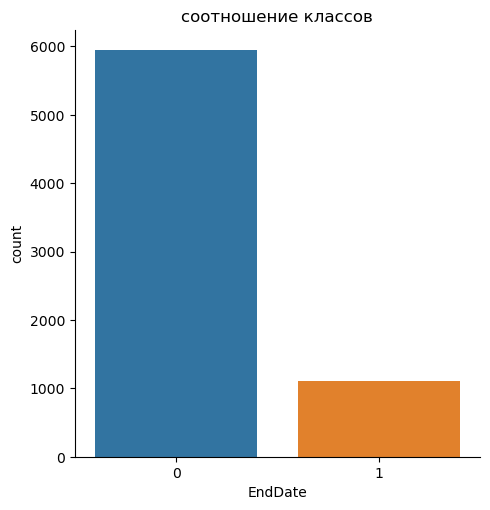

In [33]:
ax = sns.catplot(x='EndDate', kind='count', data=data)
plt.title('соотношение классов')
plt.show()

In [34]:
class_0 = data['EndDate'][data['EndDate']==0].count() / data['EndDate'].count()
class_1 = data['EndDate'][data['EndDate']==1].count() / data['EndDate'].count()

In [35]:
print(f'соотношение классов 1 к 0: {class_1:.0%} / {class_0:.0%}')

соотношение классов 1 к 0: 16% / 84%


Наблюдается дисбаланс, отток клиентов составляется 16 % от общего числа. Для борьбы с дисбалансом никаких специальных мер не предпринимаем, но используем метрику AUC-ROC, не чувствительную к дисбалансу.

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   EndDate           7043 non-null   int64  
 6   Type              7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   float64
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null   object 


### Распределение признаков

#### Распределение количественных признаков

In [37]:
def num_plot(feature, title, width):
    plt.figure(figsize=(12, 6))
    sns.histplot(data=data, x=feature, hue='EndDate', element='step', stat='density', common_norm=False, binwidth=width)
    plt.title(title)
    plt.show() 

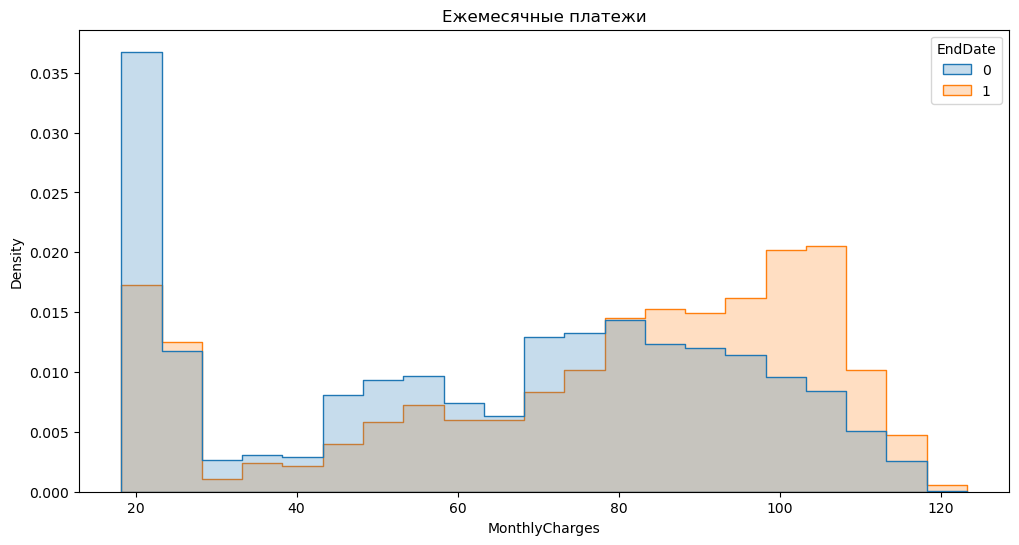

In [38]:
num_plot('MonthlyCharges', 'Ежемесячные платежи', 5)

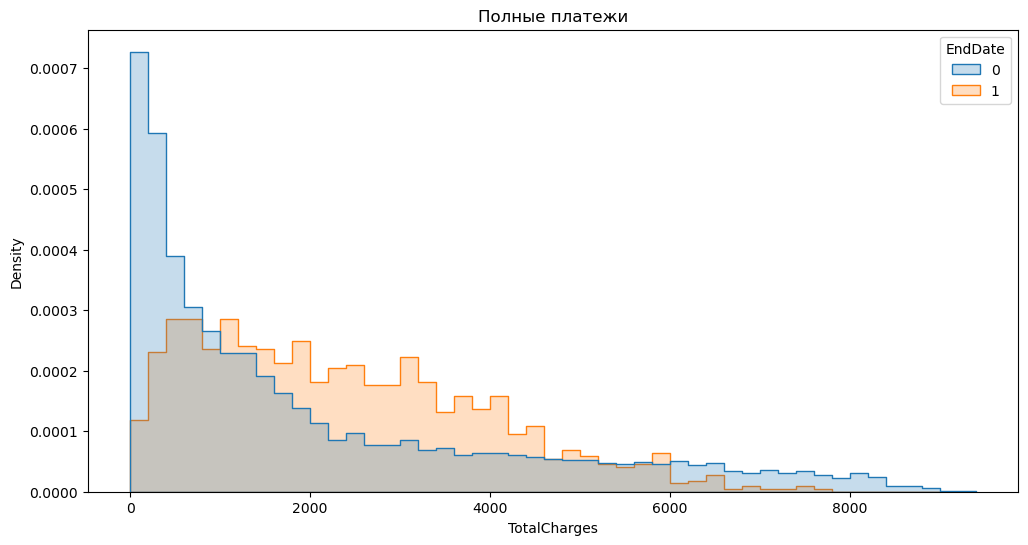

In [39]:
num_plot('TotalCharges', 'Полные платежи', 200)

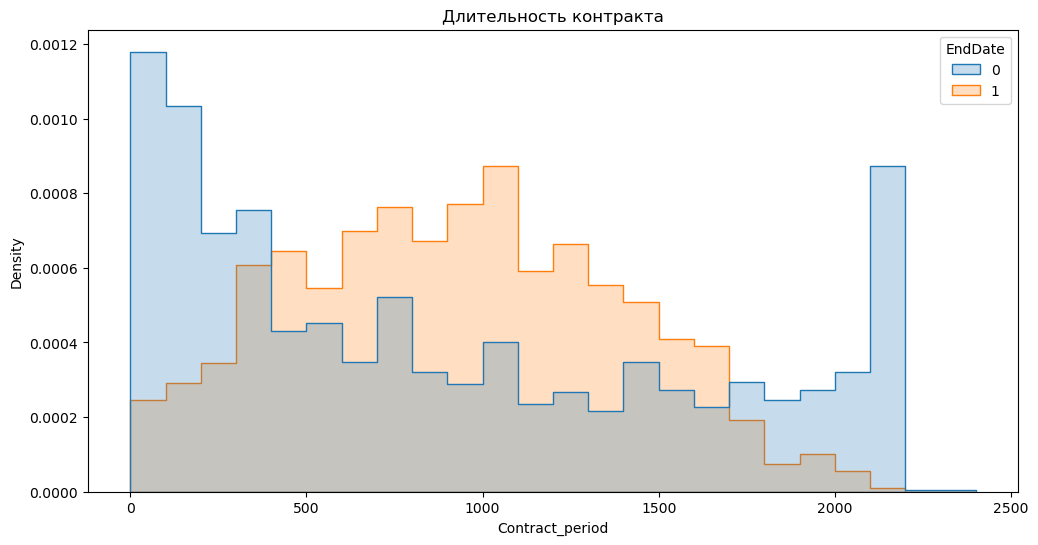

In [40]:
num_plot('Contract_period', 'Длительность контракта', 100)

  На графиках можно определить диапазоны более высокого оттока клиетов:
  - ежемесячный платеж: начиная с 80;
  - полный платеж: от 1000 до 5000;
  - длительность контракта: от 400 до 1700

#### Распределение категориальных признаков

In [41]:
def cat_plot(feature, title):
    plt.figure(figsize=(6, 6))
    sns.barplot(data=data, x=feature, y='EndDate', ci=None)
    plt.axhline(data['EndDate'].mean(), color='red', linestyle='--')
    plt.title(title)
    plt.show()

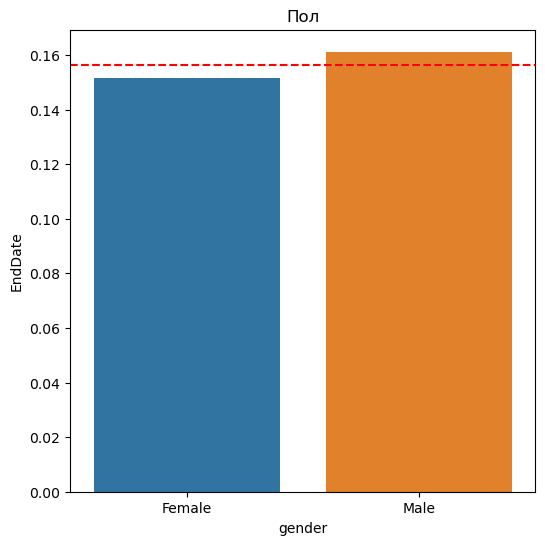

In [42]:
cat_plot('gender', 'Пол')

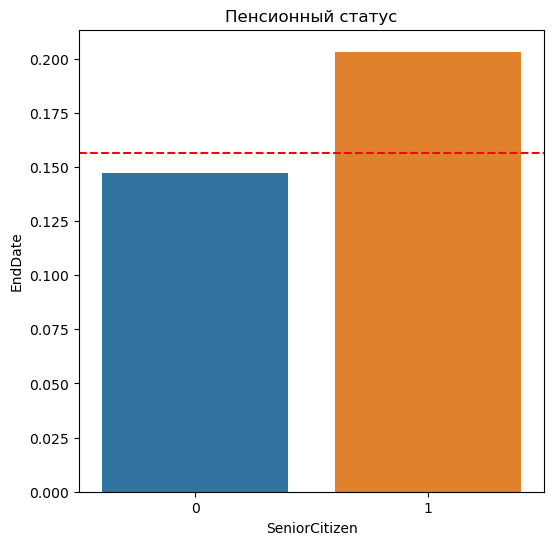

In [43]:
cat_plot('SeniorCitizen', 'Пенсионный статус')

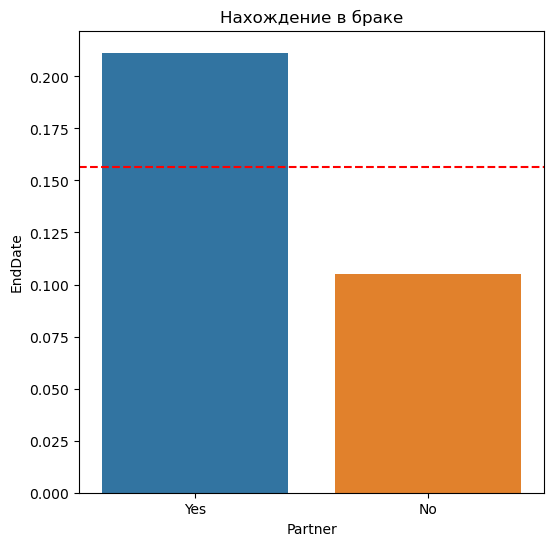

In [44]:
cat_plot('Partner', 'Нахождение в браке')

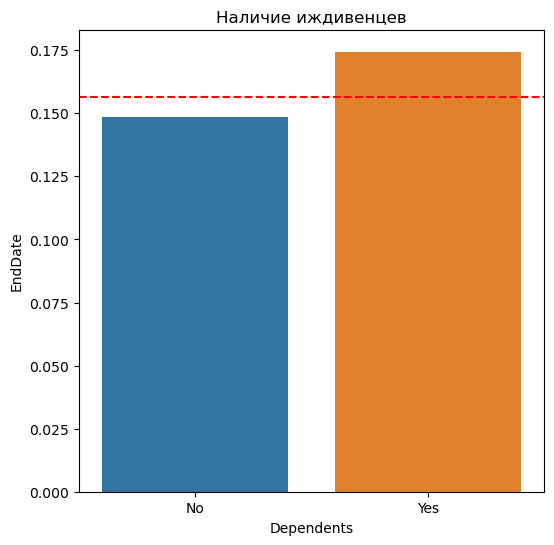

In [45]:
cat_plot('Dependents', 'Наличие иждивенцев')

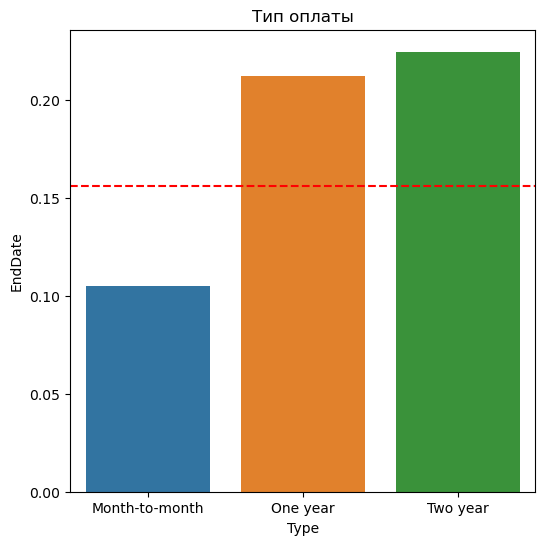

In [46]:
cat_plot('Type', 'Тип оплаты')

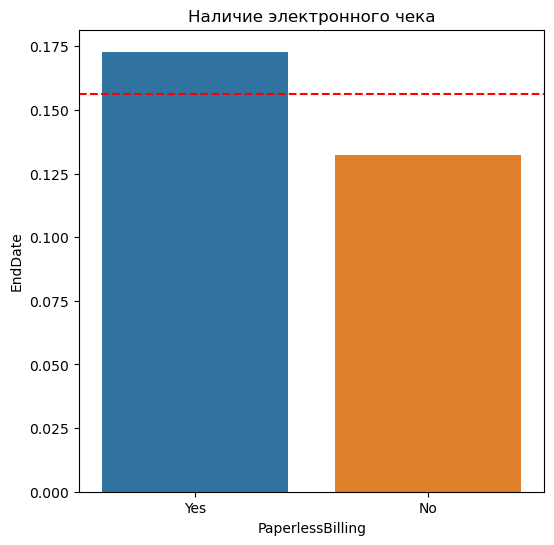

In [47]:
cat_plot('PaperlessBilling', 'Наличие электронного чека')

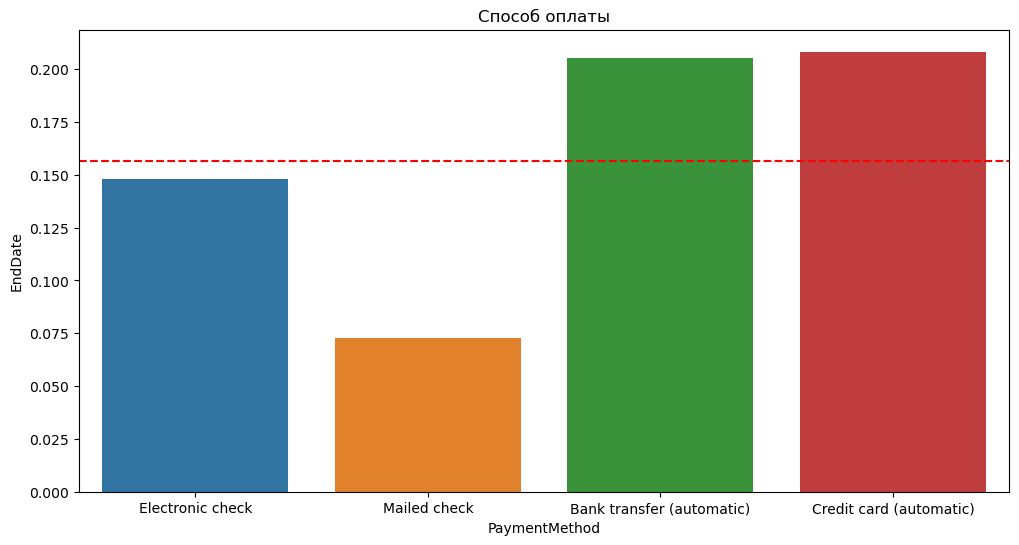

In [48]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='PaymentMethod', y='EndDate', ci=None)
plt.axhline(data['EndDate'].mean(), color='red', linestyle='--')
plt.title('Способ оплаты')
plt.show()

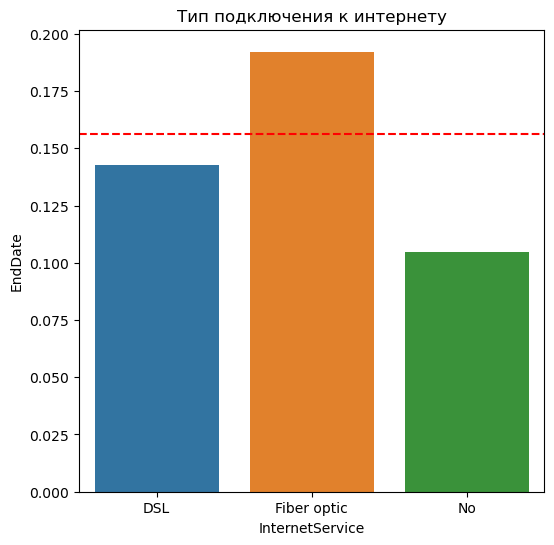

In [49]:
cat_plot('InternetService', 'Тип подключения к интернету')

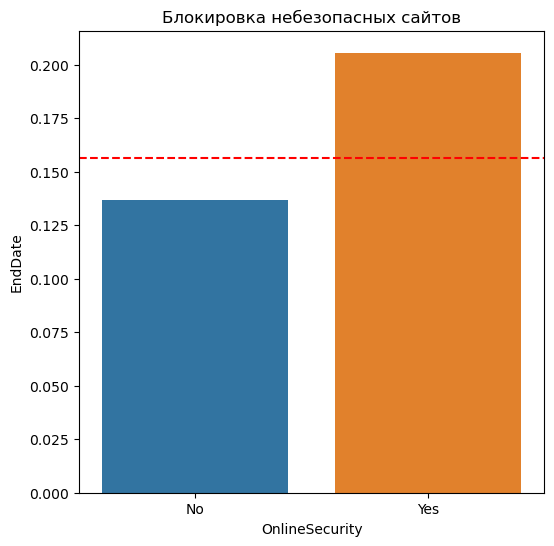

In [50]:
cat_plot('OnlineSecurity', 'Блокировка небезопасных сайтов')

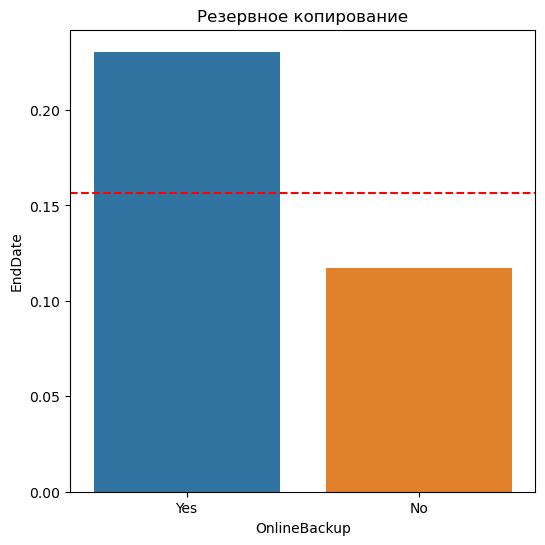

In [51]:
cat_plot('OnlineBackup', 'Резервное копирование')

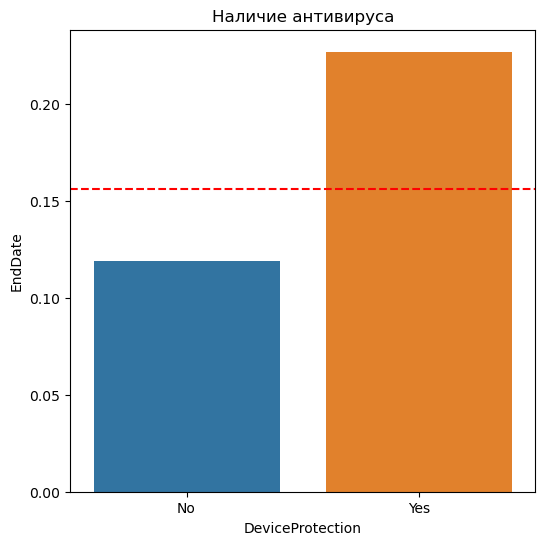

In [52]:
cat_plot('DeviceProtection', 'Наличие антивируса')

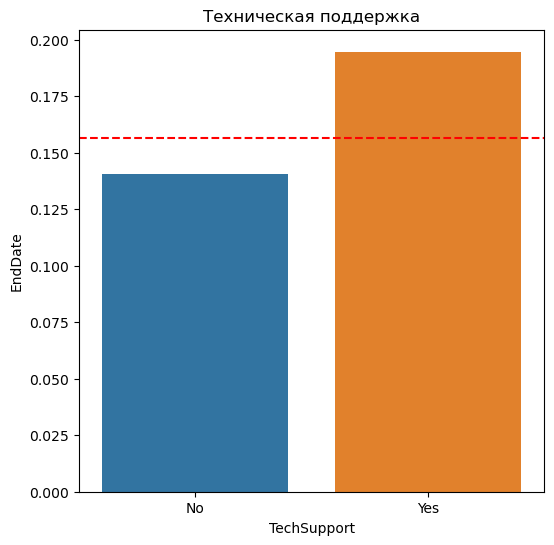

In [53]:
cat_plot('TechSupport', 'Техническая поддержка')

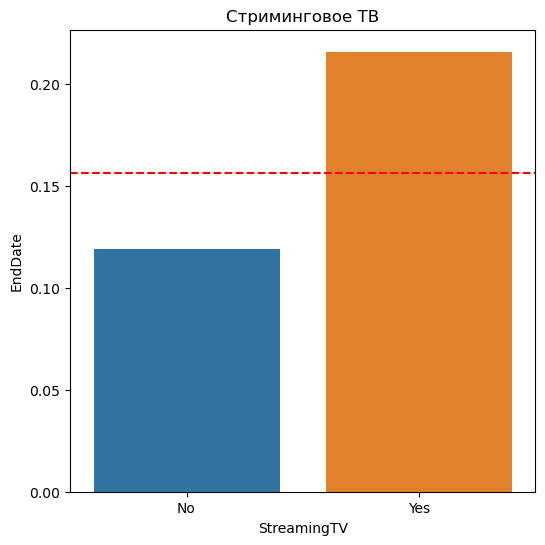

In [54]:
cat_plot('StreamingTV', 'Стриминговое ТВ')

Равное сооношение среди ушедших клиентов

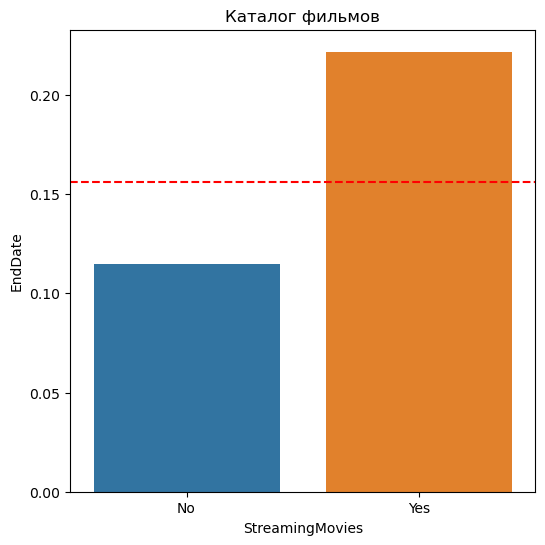

In [55]:
cat_plot('StreamingMovies', 'Каталог фильмов')

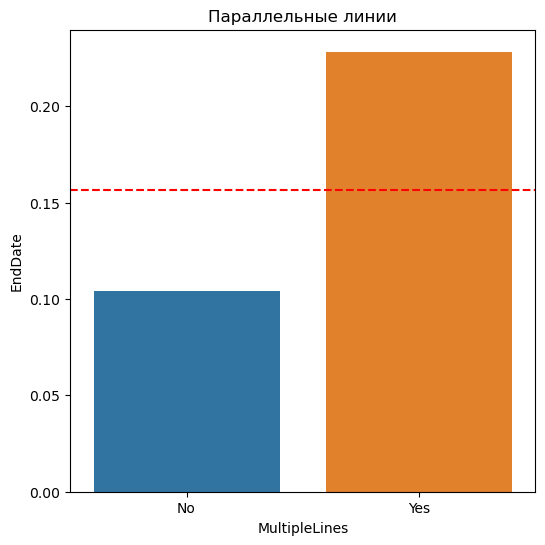

In [56]:
cat_plot('MultipleLines', 'Параллельные линии')

Отметим признаки, в которых наблюдается значительное различие относительно доли ушедших клиентов:
- нахождение в браке (больше уходит тех, кто находится в браке);
- тип оплаты (годовой);
- способ оплаты (банковские переводы);
- тип подключения (оптоволокно);
- интернет,ТВ и телефонные услуги (больше уходят те, у кого подключены дополнитльные услуги).


#### Портрет клиента

In [57]:
data_0 = data[data['EndDate'] == 0]
data_1 = data[data['EndDate'] == 1]

In [58]:
result = {
    'Отток': 
        [data_1['MonthlyCharges'].mean(), 
         data_1['TotalCharges'].mean(), 
         data_1['Contract_period'].mean()],
    'Не отток': 
        [data_0['MonthlyCharges'].mean(), 
         data_0['TotalCharges'].mean(), 
         data_0['Contract_period'].mean()]
}
result_df = pd.DataFrame(result, index=['Ежемесячный платеж', 'Общий платеж','Длительность контракта'])
result_df['Относительная разница'] = (result_df['Отток'] - result_df['Не отток']) / result_df['Не отток']
result_df

,Отток,Не отток,Относительная разница
Ежемесячный платеж,75.546004,62.763455,0.203662
Общий платеж,2371.377275,2067.866420,0.146775
Длительность контракта,924.863760,893.681084,0.034892


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   EndDate           7043 non-null   int64  
 6   Type              7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   float64
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null   object 


In [60]:
result = {
    'Отток': 
        [data_1['gender'].mode()[0], 
         data_1['SeniorCitizen'].mode()[0], 
         data_1['Partner'].mode()[0],
         data_1['Dependents'].mode()[0],
         data_1['Type'].mode()[0],
         data_1['PaperlessBilling'].mode()[0],
         data_1['PaymentMethod'].mode()[0],
         data_1['InternetService'].mode()[0],
         data_1['OnlineSecurity'].mode()[0],
         data_1['OnlineBackup'].mode()[0],
         data_1['DeviceProtection'].mode()[0],
         data_1['TechSupport'].mode()[0],
         data_1['StreamingTV'].mode()[0],
         data_1['StreamingMovies'].mode()[0],
         data_1['MultipleLines'].mode()[0]],
    'Не отток': 
        [data_0['gender'].mode()[0], 
         data_0['SeniorCitizen'].mode()[0], 
         data_0['Partner'].mode()[0],
         data_0['Dependents'].mode()[0],
         data_0['Type'].mode()[0],
         data_0['PaperlessBilling'].mode()[0],
         data_0['PaymentMethod'].mode()[0],
         data_0['InternetService'].mode()[0],
         data_0['OnlineSecurity'].mode()[0],
         data_0['OnlineBackup'].mode()[0],
         data_0['DeviceProtection'].mode()[0],
         data_0['TechSupport'].mode()[0],
         data_0['StreamingTV'].mode()[0],
         data_0['StreamingMovies'].mode()[0],
         data_0['MultipleLines'].mode()[0]]
}
result_df = pd.DataFrame(result, index=data.
                         drop(['customerID','EndDate','MonthlyCharges', 'TotalCharges', 'Contract_period'], axis=1).
                         columns)
result_df

,Отток,Не отток
gender,Male,Male
SeniorCitizen,0,0
Partner,Yes,No
Dependents,No,No
Type,Month-to-month,Month-to-month
PaperlessBilling,Yes,Yes
PaymentMethod,Electronic check,Electronic check
InternetService,Fiber optic,Fiber optic
OnlineSecurity,No,No
OnlineBackup,Yes,No


In [61]:
data['TechSupport'].value_counts()

No     4999
Yes    2044
Name: TechSupport, dtype: int64

Приблизительный портрет клиента, готовящегося уйти:
- состоящий в браке, 
- предпочитающий годовой/двухгодовой способ оплаты, 
- в среднем платящий больше,
- имеющий всевозможные доролнительные услуги.

### Оценка корреляции

In [62]:
coll_matrix = data.drop('customerID', axis=1).phik_matrix(interval_cols=['MonthlyCharges','TotalCharges','Contract_period'])

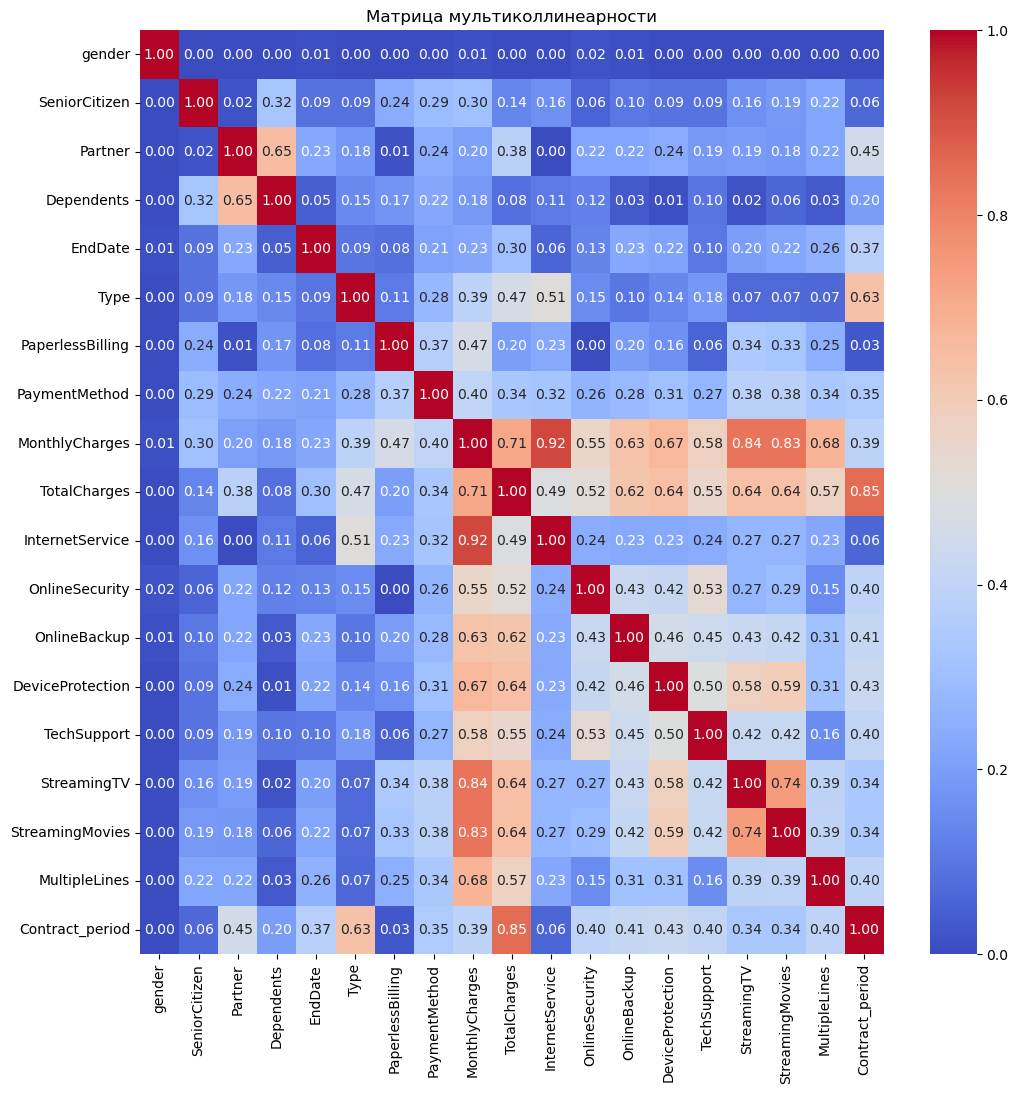

In [63]:
plt.figure(figsize=(12,12))
sns.heatmap(coll_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица мультиколлинеарности')
plt.show()


Отметим признаки, значение корреляции между которыми не менее 0.8:
- признак ежемесячных трат коррелирует сразу с тремя: тип подключения к интернету, стриминговое ТВ и фильмы;
- принак общих трат коррелирует с длительностью контракта.

Чтобы избавиться от коллинеарности признаков, для обучения модели оставим призаки ежемесячных трат и  длительности конракта, поскольку они имеют более высокую корреляцию с целевым признаком.

### Подготовка к обучению модели

#### Разбиение на обучающую и тестовую выборку

In [64]:
features = data.drop(columns=['customerID','EndDate','InternetService','StreamingTV','StreamingMovies','TotalCharges'], axis=1)
target = data['EndDate']

In [65]:
features_train, features_test, target_train, target_test = train_test_split(
                features, target, test_size=0.25, random_state=3072023, stratify=target)

In [66]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 12 to 1958
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5282 non-null   object 
 1   SeniorCitizen     5282 non-null   int64  
 2   Partner           5282 non-null   object 
 3   Dependents        5282 non-null   object 
 4   Type              5282 non-null   object 
 5   PaperlessBilling  5282 non-null   object 
 6   PaymentMethod     5282 non-null   object 
 7   MonthlyCharges    5282 non-null   float64
 8   OnlineSecurity    5282 non-null   object 
 9   OnlineBackup      5282 non-null   object 
 10  DeviceProtection  5282 non-null   object 
 11  TechSupport       5282 non-null   object 
 12  MultipleLines     5282 non-null   object 
 13  Contract_period   5282 non-null   int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 619.0+ KB


#### Кодирование OneHot и масштабирование

In [67]:
X_num = features_train.select_dtypes(exclude='object').columns.to_list()
X_cat = features_train.drop(columns=['MonthlyCharges','Contract_period'], axis=1).columns.to_list()

In [68]:
X_num.remove('SeniorCitizen')

In [69]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), X_num),
        ('cat', Pipeline(steps=[('encoder', OneHotEncoder(drop='first', sparse=False))]), X_cat),
    ]
    )

In [70]:
transformed = preprocessor.fit_transform(features_train)
categorical_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(X_cat)
all_features = X_num + list(categorical_columns)

In [71]:
trans_df = pd.DataFrame(transformed, columns=all_features)
trans_df

,MonthlyCharges,Contract_period,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,MultipleLines_Yes
0,1.183760,1.265756,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.339759,0.327126,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,1.273377,0.908462,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.506656,-0.787222,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.500703,-1.141588,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,0.885037,1.886628,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
5278,1.130654,-0.517787,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
5279,0.665974,0.195337,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5280,-0.484107,-1.276305,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Обучение модели

### Логистическая регрессия

In [72]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=3072023, solver='liblinear'))
])
scores = cross_val_score(pipeline, features_train, target_train, cv=5, scoring='roc_auc')
print("Logistic Regression: mean_cross_val_score = {:.3f}".format(scores.mean()))

Logistic Regression: mean_cross_val_score = 0.757


### Градиентный бустинг 

In [73]:
pipeline = Pipeline(steps=[
    ('classifier', CatBoostClassifier(
        random_state=3072023,
        cat_features=X_cat,
        silent=True
    ))
])

In [ ]:
params = {
    'classifier__iterations':range(100,1000,100),
    'classifier__learning_rate':np.arange(0.001,0.5,0.01),
    'classifier__depth': range(1, 15, 1) 
}

cat = RandomizedSearchCV(pipeline,
        params,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,        
        n_iter=20)

cat.fit(features_train, target_train)

In [ ]:
cat.best_params_

In [73]:
pipeline = Pipeline(steps=[
    ('classifier', CatBoostClassifier(
        learning_rate=0.41,
        iterations=500,
        depth=3,
        random_state=3072023,
        cat_features=X_cat,
        verbose=0
    ))
])
scores = cross_val_score(pipeline, features_train, target_train, cv=5, scoring='roc_auc')
print("CatBoostClassifier: mean_cross_val_score = {:.2f}".format(scores.mean()))

CatBoostClassifier: mean_cross_val_score = 0.92


Проверим модель градиентного бустинга на тестировании

## Тестирование

In [74]:
pipeline.fit(features_train, target_train)
pred_probabilities = pipeline.predict_proba(features_test)[:, 1]
predictions = pipeline.predict(features_test)
print(classification_report(target_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1486
           1       0.88      0.64      0.74       275

    accuracy                           0.93      1761
   macro avg       0.91      0.81      0.85      1761
weighted avg       0.93      0.93      0.93      1761



In [75]:
print('AUC-ROC для CatBoostClassifier на тестовой выборке: ', roc_auc_score(target_test, pred_probabilities).round(2))
print('Accuracy для CatBoostClassifier на тестовой выборке: ', accuracy_score(target_test, predictions).round(2))

AUC-ROC для CatBoostClassifier на тестовой выборке:  0.93
Accuracy для CatBoostClassifier на тестовой выборке:  0.93


Accuracy 0.93 показывает, что модель делает верный прогноз (останентся клиент или уйдет) в 93 % случаях.

In [76]:
fpr, tpr, thresholds = roc_curve(target_test, pred_probabilities)
roc_auc = roc_auc_score(target_test, pred_probabilities)

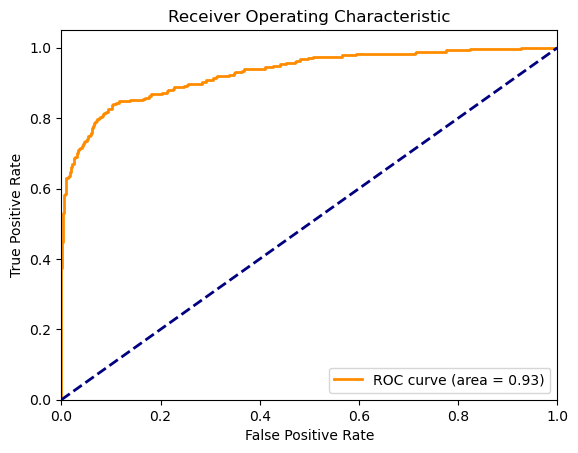

In [77]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Матрица ошибок

In [78]:
c_mat = confusion_matrix(target_test, pipeline.predict(features_test))

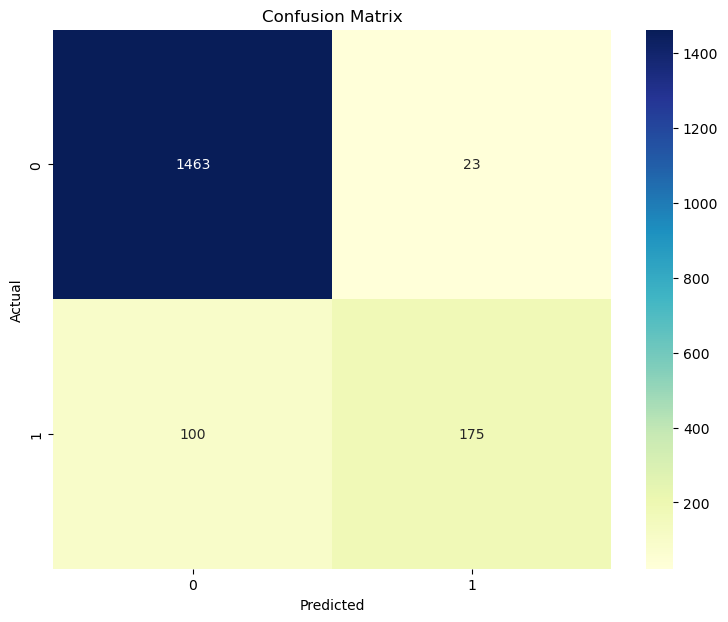

In [79]:
class_names = pipeline.classes_ 
c_mat_df = pd.DataFrame(c_mat, index=class_names, columns=class_names)

plt.figure(figsize=(9, 7))
sns.heatmap(c_mat_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Всего в тестовой выборке 1761 клиент. Мы получили следующие значения матрицы ошибок:
- TN = 1463 - модель верно предсказала количество оставшихся клиентов;
- FP = 23 - модель ошибочно предсказала уход клиентов;
- FN = 100 - модель ошибочно предсказала количество оставшихся клиентов;
- TP = 175 - модель верно предсказала количество ушедших клиетов.

Итого, среди 275 ушедших клиентов, модель верно предсказала 175, что составляет чуть более 63 %.

## Важность признаков

In [80]:
cat = pipeline.named_steps['classifier']
cat_features = pd.DataFrame({'features': cat.feature_names_,
                             'score': cat.get_feature_importance()}).sort_values(by="score", ascending = False)


In [81]:
cat_features

,features,score
13,Contract_period,66.686645
7,MonthlyCharges,13.399388
4,Type,5.449870
6,PaymentMethod,3.481687
2,Partner,2.110947
12,MultipleLines,2.034480
9,OnlineBackup,1.627490
10,DeviceProtection,1.224388
3,Dependents,0.808388
8,OnlineSecurity,0.703406


In [82]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.barplot(ax=ax, x=cat_features["score"], y=cat_features["features"]);

График показывает, что признак длительности контракта с подавляющим перевесом имеет наибольшую важность для предсказания целевого признака модели градиентного бустинга. Также признак ежемесячной оплаты оказывает значительное влияние. 

## Вывод

В данном проекте необходимо создать модель, предсказывающую отток клиентов телеком-компании для лучшего реагирования руководства на исправление ситуации. В нашем распоряжении 4 датасета: сведения о контрактах, персональные данные, интернет и телефонные услуги.

Для реализации проекта было сделано следующее:
- проведен исследовательский анализ и предобработка данных:
    - проверено отсутствие дубликатов;
    - все датасеты сведены в общую таблицу;
    - пропуски заполнены;
    - создан признак длительности контракта;
    - типы данных преобразованы;
    - создан целевой признак с двумя категориями (1- клиент ушел, 0 - клиент остался);
    - исследовано соотношение классов (1 - 14 %,0 - 86 %);
    - исследовано распредление признаков;
    - проведена оценка корреляции, в результате найдены мульколлинеарные признаки;
    - разбиение датасета на обучающую и тестовую выборки;
    - кодирование категориальлных признаков техникой OneHotEncoding и масштабирование количественных для обучения логистической регрессии.
    
    Было обучено две модели: логистической регрессии и градиентного бустинга. Лучшей была выбрана модель градиентного бустинга с метрикой AUC-ROC 0.93. На тестировании модель показала ту же метрику.
    
    Дополнительно оценан метрика Acuracy=0.93 (модель верно дайет прогноз в 93 % случаях).
    
    Матрица ошибок показала, что среди ушедших клиентов, модели верно прогнозирует приемрно в 64 % случаях.
    
    Среди признаков оказывающих наиболее выделяются длительность контракта и ежемесячные траты.


## Отчет по проекту

### Шаги работы над проектом

Для реализации проекта были запланированы и осуществлены следующие шаги:
- исследовательский анализ и предобработка данных:
    - проверка отсутствия дубликатов;
    - сведение данных в общую таблицу;
    - заполнение пропусков;
    - создание дополнительного признака;
    - преобразование типов данных;
    - создание целевого признака;
    - исследование соотношения классов;
    - исследование распределения признаков;
    - оценка корреляции признаков;
    - удаление признаков, не оказывающих положительного влияния на обучение модели;
    - разбиение датасета на обучающую и тестовую выборки;
    - кодирование и масштабирование признаков;
- обучение моделей (два разных алгоритма);
- выбор лучшей модели по метрике AUC-ROC и ее тестирование;
- оценка метрики Accuracy;
- оценка матрицы ошибок;
- оценка важности признаков;
- общий вывод.

### Анализ работы фактической работы запланированным шагам

Работа в целом велась в соответствии с планом. 

Различия:
- кодирование и масштабирование признаков проводилась после разбиения на тренировочную и тестовую выборки;
- дополнительно были проанализированы матрица ошибок и метрика Accuracy.

### Возникшие сложности и пути их решения

Основная сложность - определить, какие признаки из набора оказывают действительно значимое влияние на обучение модели. Путем решения стали анализ распределения и корреляции признаков.

### Список признаков для обучения модели

Итоговый список признаков для обучения модели:
- категориальные:
    - gender - пол клиента;
    - SeniorCitizen - пенсионный статус;  
    - Partner - состояние в браке; 
    - Dependents - наличие иждивенцев;
    - Type - тип оплаты; 
    - PaperlessBilling - наличие электронного платежного документа;
    - PaymentMethod - способ оплаты;
    - OnlineSecurity - наличие онлайн безопасности;
    - OnlineBackup - наличие резервного копирования онлайн;
    - DeviceProtection - наличие защиты устройства; 
    - TechSupport - наличие технической поддержки; 
    - MultipleLines - наличие возможности ведения параллельных линий во время звонка; 
    
- количественные:
    - MonthlyCharges - ежемесячные траты на услуги;
    - Contract_period - длительность контракта.
    
Признак длительности контракта был создан.

Для модели логистической регрессии категориальные признаки кодировались техникой OneHot, количественные масштабировались.

Для модели градиентного бустинга кодирование категориальных признаков осуществлялось встроенными методами CatBoost.
    

### Описание предобработки данных

Выполнены следующие шаги:
- все представленные датасеты сведены в общую таблицу по столбцу с идентификатором клиента, образовавшиеся пропуски в услугах интернета и телефона заполнены значением отсутствия услуг;
- измененены типы данных:
    - суммарные траты приведены к численному значению вместо строкового;
    - дата начала контракта приведены к формату даты/времени;
- создан признак длительности контракта в сутках;
- создан целевой признак с двумя классами (положительный - клиент ушел, отрицательный - клиент остался);
- исследовано соотношение классов (положительный - 14 %, отрицательный - 86 %);
- исследовано распредление признаков, выявлены признаки, где наблюдается изменение картины распределения:
    - состояние в браке;
    - наличие резервного копирование онлайн;
    - наличие защиты устройства;
    - стриминговое ТВ и фильмы;
    - наличие возможности параллельных линий;
    - ежемесячные и общие траты;
    - длительность контракта; 
- проведена оценка корреляции (см. приложение 1), в результате найдены мульколлинеарные признаки:
    - признак ежемесячных трат коррелирует сразу с тремя: Интернет-сервис, стриминговое ТВ и фильмы;
    - признак общих трат коррелирует с длительностью контракта.
    Чтобы избавиться от коллинеарности признаков, для обучения модели в последствии оставили признаки ежемесячных трат и  длительности конракта, поскольку они имеют более высокую корреляцию с целевым признаком;
    - удаление ненужных признаков;   
- разбиение датасета на обучающую и тестовую выборки в соотношении 3/1;
- кодирование категориальлных признаков техникой OneHotEncoding и масштабирование количественных для обучения логистической регрессии.

Приложение 1 - Матрица мультиколлинеарности

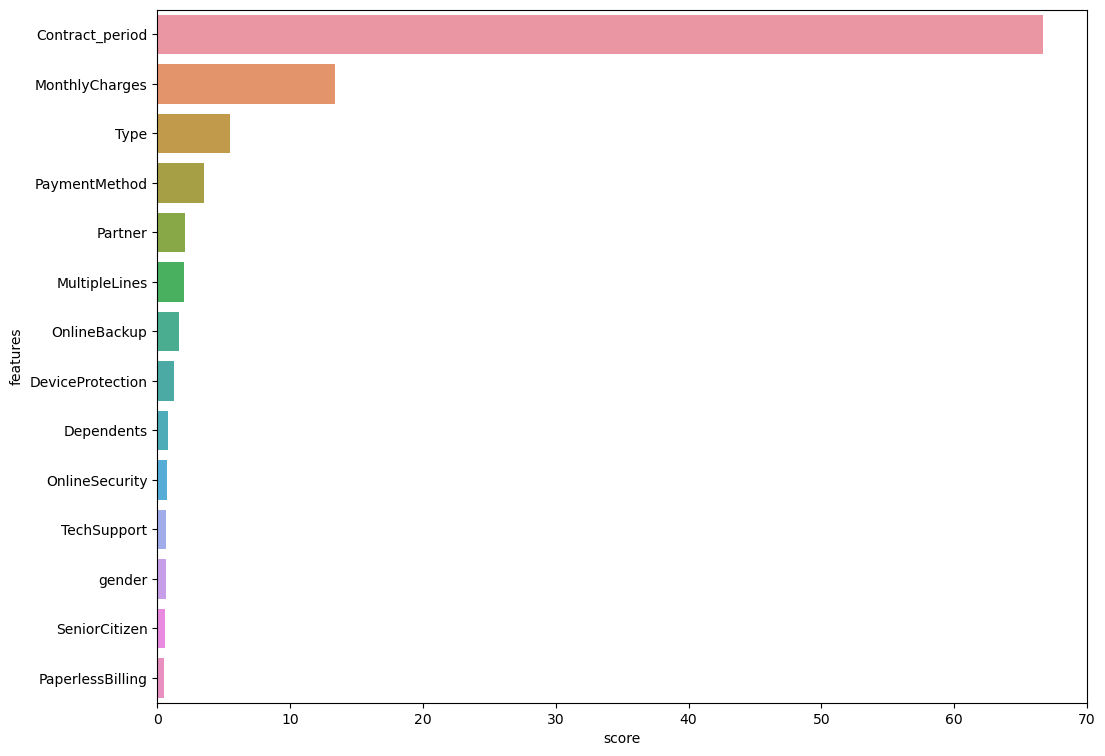

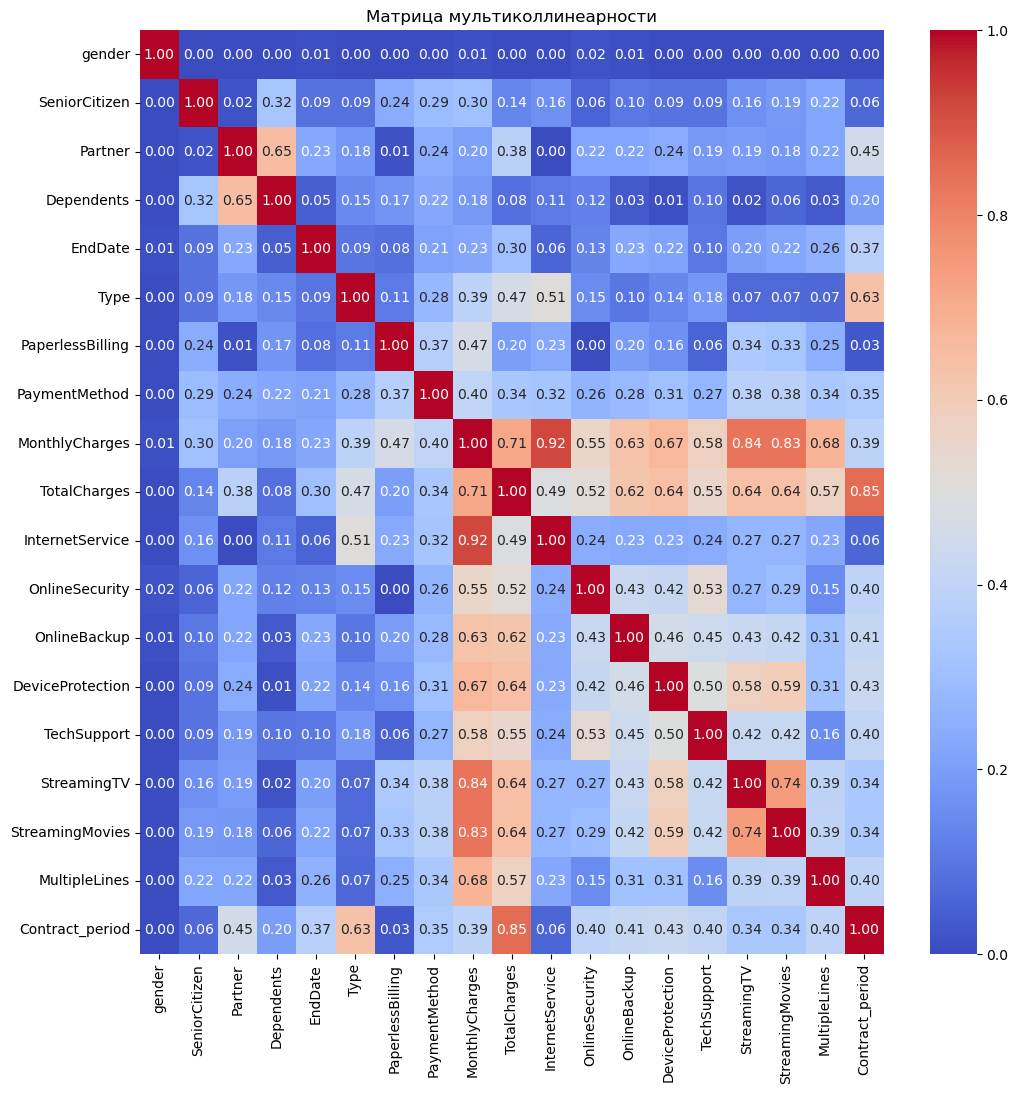

In [83]:
plt.figure(figsize=(12,12))
sns.heatmap(coll_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица мультиколлинеарности')
plt.show()


### Исследование моделей

Были исследованы две модели:
- логистическая регрессия; 
- градиентный бустинг Cat Boost.

Лучшая модель - CatBoost:
- гиперпараметры:
    - learning rate - 0.41;
    - depth - 3;
    - iterations - 500;
- метрика AUC-ROC на кросс-валидации - 0.93 (у регрессии 0.76);
- метрика AUC-ROC на тестировании - 0.93
- метрика Accuracy на тестировании - 0.93, то есть модель верно предсказывает в 93 % случаях.


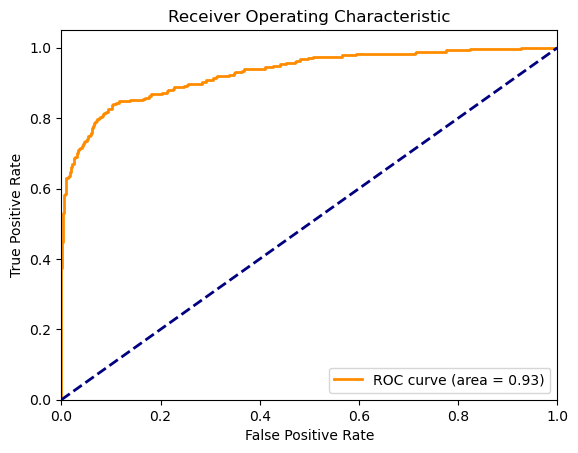

In [84]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Матрица ошибок

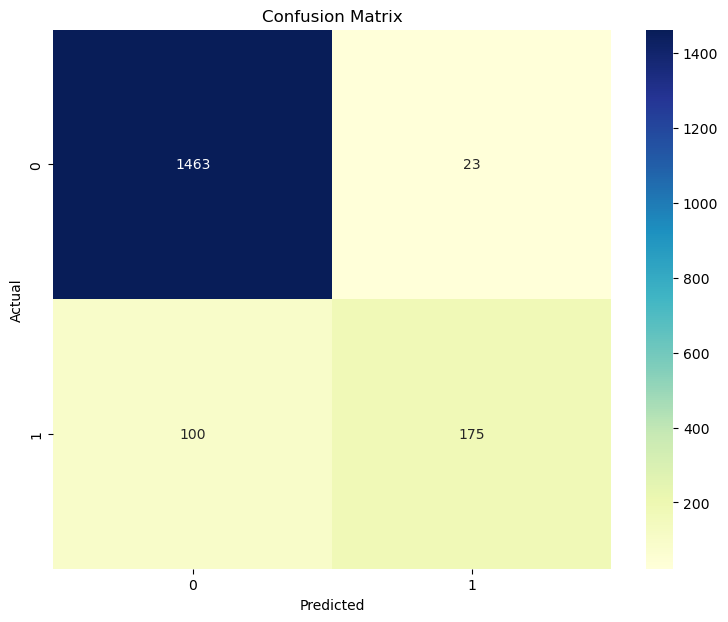

In [85]:
plt.figure(figsize=(9, 7))
sns.heatmap(c_mat_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Всего в тестовой выборке 1761 клиент. Мы получили следующие значения матрицы ошибок:
- TN = 1463 - модель верно предсказала количество оставшихся клиентов;
- FP = 23 - модель ошибочно предсказала уход клиентов;
- FN = 100 - модель ошибочно предсказала количество оставшихся клиентов;
- TP = 175 - модель верно предсказала количество ушедших клиетов.

По этим значениям можно посчитать важные метрики:

- Accuracy (93.0%): Тоность предсказаний модели.

- Precision (88.4%): Точность предсказаний оттока говорит о том, что когда модель предсказывает, что клиент уйдет, она в большинстве случаев права.

- Recall или FPR(63.6%): Доля ушедших клиентов, предсказанных моделью, среди реально ушедших клиентов.

- FPR (1.5%): Доля ушедших клиентов, предсказанных моделью, среди реально оставшихся клиентов. 


### Важность признаков

In [86]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.barplot(ax=ax, x=cat_features["score"], y=cat_features["features"]);

График показывает, что признак длительности контракта с подавляющим перевесом имеет наибольшую важность для предсказания целевого признака модели градиентного бустинга. Также признак ежемесячной оплаты оказывает значительное влияние. 